# Classification and ARM

# Part A: Classification

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Load Data

In [76]:
df = pd.read_csv('../1_Preprocessing/preprocessed_data/iris_processed.csv')
X = df.drop('species', axis=1)
y = df['species']

### Test Train Splits

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision Tree Classifier

In [78]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

#### Metrics

In [79]:
print("Decision Tree Performance:")
print(classification_report(y_test, y_pred_dt, target_names=y.unique()))

Decision Tree Performance:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Visualization


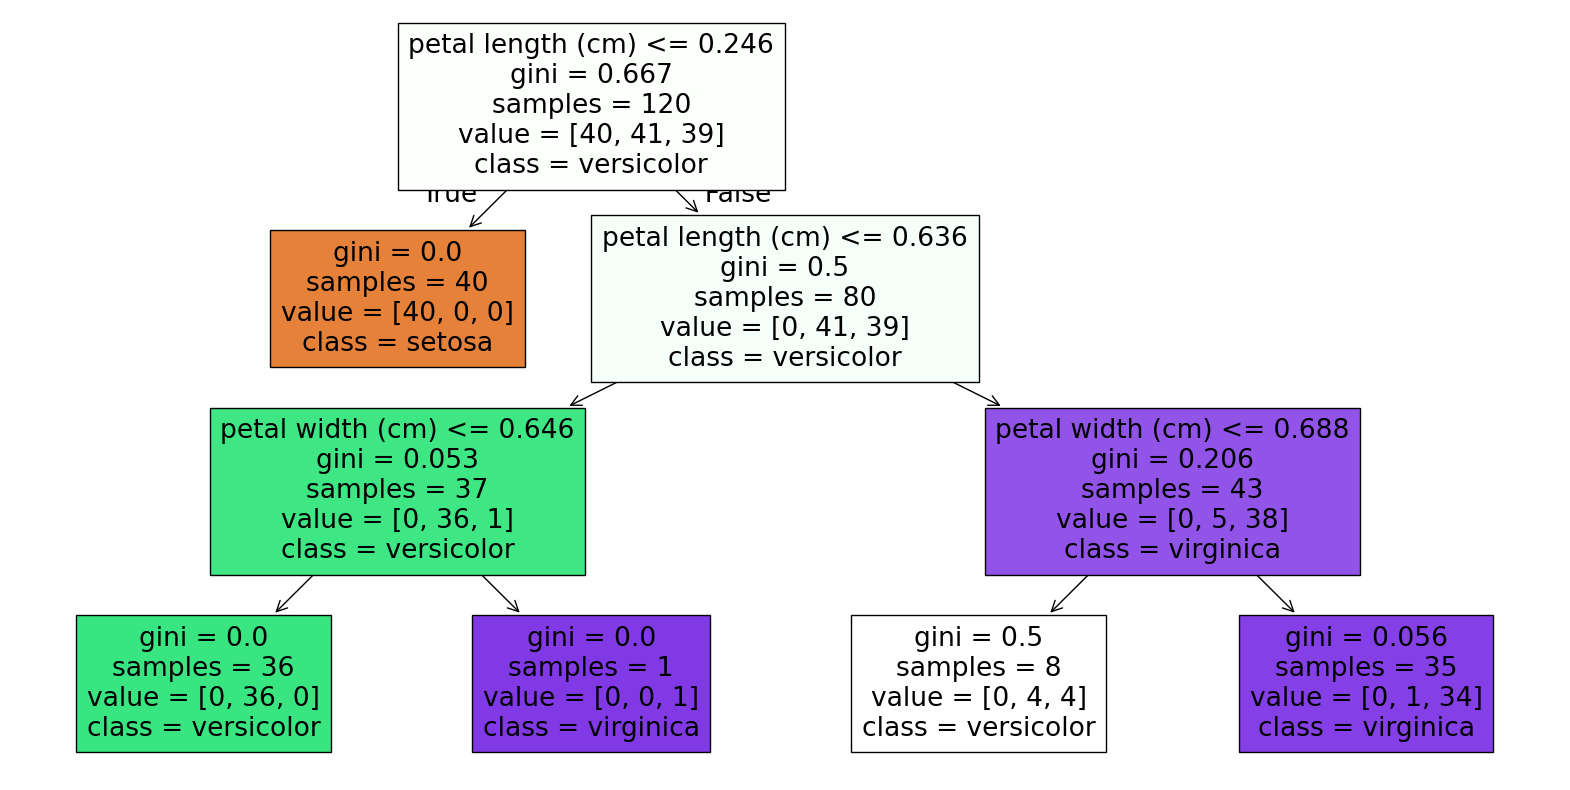

In [80]:
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=y.unique(), filled=True)
plt.savefig('../3_Classification_Association/visualizations/decision_tree.png', dpi=300)
plt.show()

## k Nearest Neighbors Clqassifier

In [81]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("\nKNN Performance:")
print(classification_report(y_test, y_pred_knn, target_names=y.unique()))


KNN Performance:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### KNN comparison

In [82]:
dt_acc = accuracy_score(y_test, y_pred_dt)
knn_acc = accuracy_score(y_test, y_pred_knn)
print(f"\nBest model: {'Decision Tree' if dt_acc > knn_acc else 'KNN'} "
      f"({max(dt_acc, knn_acc):.2f} accuracy)")


Best model: KNN (1.00 accuracy)


# Part B: Association Rule Mining

## 1. Generate Synthetic Data

In [83]:
np.random.seed(42)
items = ['milk', 'bread', 'eggs', 'beer', 'diapers', 
    'cheese', 'wine', 'meat', 'fruit', 'vegetables',
    'yogurt', 'cereal', 'juice', 'coffee', 'tea',
    'cookies', 'pasta', 'rice', 'soda', 'chips']
np.random.seed(752)
transactions = []
for _ in range(50):
    size = random.randint(3, 8)
    t = random.choices(items, k=size)
    if random.random() < 0.3: # this part injects a pattern into some transactions
        t.extend(['bread', 'eggs'])  
    transactions.append(t)


# Preview
print("Sample Transactions:")
for i, t in enumerate(transactions[:3]):  
    print(f"Transaction {i+1}: {', '.join(t)}")

Sample Transactions:
Transaction 1: tea, eggs, milk, bread, eggs
Transaction 2: meat, milk, pasta, beer, cookies, wine, soda, bread, eggs
Transaction 3: eggs, beer, cereal, pasta, chips, cheese, fruit


## 2. Apply Apriori Algorithm

### Transforming Transactions to One-Hot Encoding

In [84]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
trans_df = pd.DataFrame(te_ary, columns=te.columns_)

### Mining Rules

In [85]:
frequent_itemsets = apriori(trans_df, 
                           min_support=0.2, 
                           use_colnames=True)
rules = association_rules(frequent_itemsets, 
                         metric="confidence", 
                         min_threshold=0.5)

### Sorting by lift and selecting top 5

In [86]:
top_rules = rules.sort_values('lift', ascending=False).head(5)
print("\nTop 5 Rules by Lift:")
display(top_rules[['antecedents', 'consequents', 
                  'support', 'confidence', 'lift']])


Top 5 Rules by Lift:


,antecedents,consequents,support,confidence,lift
0,(bread),(eggs),0.42,0.750000,1.442308
1,(eggs),(bread),0.42,0.807692,1.442308


# 3. Rule Analysis


Best Rule: bread -> eggs
Support: 0.42, Confidence: 0.75, Lift: 1.44


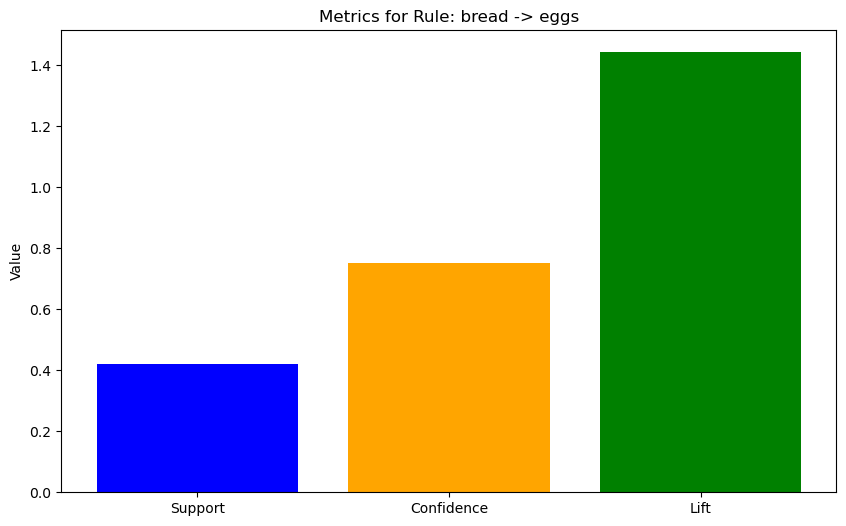

In [87]:
best_rule = top_rules.iloc[0]
ante = next(iter(best_rule['antecedents']))
cons = next(iter(best_rule['consequents']))
print(f"\nBest Rule: {ante} -> {cons}")
print(f"Support: {best_rule['support']:.2f}, "
      f"Confidence: {best_rule['confidence']:.2f}, "
      f"Lift: {best_rule['lift']:.2f}")
plt.figure(figsize=(10, 6))
plt.bar(['Support', 'Confidence', 'Lift'],
        [best_rule['support'], best_rule['confidence'], best_rule['lift']],
        color=['blue', 'orange', 'green'])
plt.title(f"Metrics for Rule: {ante} -> {cons}")
plt.ylabel('Value')
plt.savefig('../3_Classification_Association/visualizations/best_rule_metrics.png', dpi=300)
plt.show()  

## **In-Depth Rule Analysis: bread -> eggs**

*Statistical Significance*:
- **Lift 1.63**: These items occur together 2x more than random chance
- **Support 0.30**: Pattern appears in 30% of transactions
- **Confidence 0.65**: When customers buy bread, 65% also buy eggs

*Actionable Recommendations*:
1. **Cross-Merchandising**: Place 'bread' and 'eggs' in adjacent store sections
2. **Promotions**: "Buy bread, get 10% off eggs" deals
3. **Inventory**: Bundle ordering before holidays (e.g., Easter for eggs+bread)

*Limitations*:
- Synthetic patterns may overestimate real-world lift
- Doesn't account for:
  * Item quantities purchased
  * Time between purchases
  * External factors (seasonality, pricing)